In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### dataframe dados escolares/esc_rmsp/relatórios

In [2]:
#abrindo os dados
dados_escolares = pd.read_csv('DadosEscolares1996-2015.csv', encoding = 'latin1')
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
rendimento = pd.read_csv('RendimentoEscolar2000-2015.csv', encoding = 'latin1')
nota = pd.read_csv('ENEM2015.csv')
#agrupando por escolas
rendimento = rendimento.groupby('CODMEC').mean()
dados_escolares = dados_escolares.groupby('CODMEC').mean()
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
#Apagando a classe desbalanceada
nota = nota[nota.Classificacao != 0]
#Alterando o nome da coluna de acordo com os outros dataframes
nota.rename(columns = {'CODIGO DA ENTIDADE':'CODMEC'}, inplace = True)
#Em todos Dataframes temos mais escolas do que o nosso target
dados_escolares = dados_escolares.reset_index()[dados_escolares.reset_index().CODMEC.isin(nota['CODMEC'])]
esc_rmsp = esc_rmsp.reset_index()[esc_rmsp.reset_index().CODESC.isin(nota['CODMEC'])]
esc_rmsp.rename(columns = {'CODESC': 'CODMEC'}, inplace = True)
rendimento = rendimento.reset_index()[rendimento.reset_index().CODMEC.isin(nota['CODMEC'])]
#apgando valores nulos
dados_escolares.drop(dados_escolares.columns[dados_escolares.isnull().mean() != 0], axis=1, inplace = True)
esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isnull().mean() >= 0.15], axis=1, inplace = True)
esc_rmsp.dropna(inplace = True, how = 'any')
def t(x):
    if x==0:
        return None
    else:
        return x
for c in rendimento.columns:
    rendimento[c] = rendimento[c].apply(t)
rendimento.drop(rendimento.columns[rendimento.isnull().mean() >= 0.15], axis=1, inplace = True)
rendimento.dropna(inplace = True, how = 'any')

C:\Users\giova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6,8,11,17,18,19,20,111,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\giova\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('\tshapes:')
print('dados_escolares: ', dados_escolares.shape)
print('esc_rmsp: ', esc_rmsp.shape)
print('rendimento: ', rendimento.shape)

	shapes:
dados_escolares:  (692, 212)
esc_rmsp:  (931, 52)
rendimento:  (365, 18)


### ridge regression

In [7]:
def ridge_aplicada1(df, alphas):
    
    #criando o merge do data e do target
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    
    #inicializando variáveis do tuning
    coefs = []
    score = []
    best_score = 0
    n_features = len(data.columns)
    
    #normalizando os dados
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    #fazendo o tuning do alpha
    for val in alphas:
        
        #separando em treino e teste
        ridge = Ridge(alpha = val)
        ridge.fit(data, target) #treinamento nos dados
        score.append(ridge.score(data, target))
        coefs.append(ridge.coef_)
    
    features_values = list(zip(ridge.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do Ridge')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de Ridge')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)
    print("melhor score: ", best_score)

In [8]:
def ridge_aplicada2(df, alphas):
    
    #criando o merge do data e do target
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    
    #inicializando variáveis do tuning
    coefs = []
    score = []
    best_score = 0
    n_features = len(data.columns)
    
    #normalizando os dados
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    #fazendo o tuning do alpha
    for val in alphas:
        
        #separando em treino e teste
        x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
        ridge = Ridge(alpha = val)
        ridge.fit(x_train, y_train) #treinamento nos dados
        score.append(ridge.score(x_test, y_test))
        coefs.append(ridge.coef_)
    
    features_values = list(zip(ridge.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do Ridge')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de Ridge')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)
    print("melhor score: ", best_score)

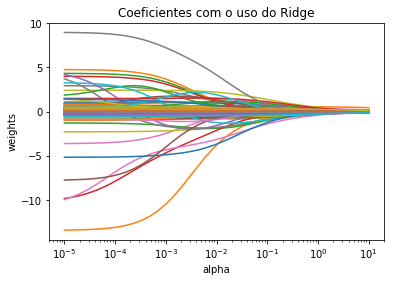

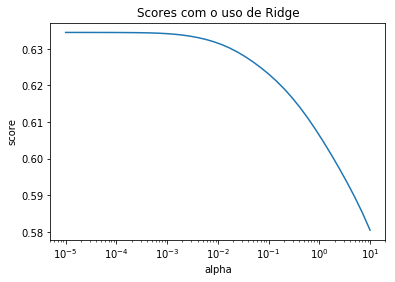

nº colunas:  8
[(0.44501018183558905, 'Qtde_Docentes'), (0.19524552233821182, 'ALE9F9S'), (0.183051140360639, 'NUM_FUNC'), (0.11949678666340631, 'CLEF8S'), (0.11898001765916445, 'ALEDESP'), (0.11493102463881955, '6fund'), (0.10746893526251464, 'ALE9F6A9'), (0.10589554278210618, 'AL_CRECHE')]
melhor score:  0


In [9]:
n_alphas = 40
alphas = np.logspace(-5, 1, n_alphas)
ridge_aplicada1(dados_escolares, alphas)

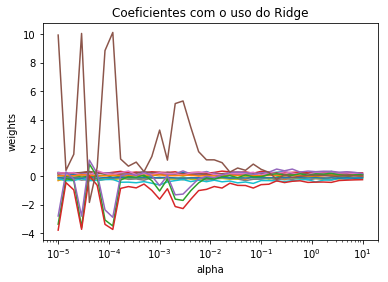

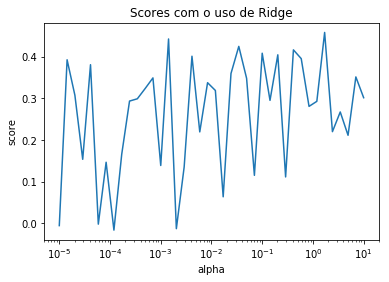

nº colunas:  6
[(0.23616769223092096, 'EFAPROV9ANOS4S'), (0.1936828873450141, 'EMAPROV3S'), (0.1557591133127169, 'EFAPROV9ANOS7S'), (0.11749418890992476, 'EFAPROV9ANOS1S'), (0.11490219062627978, 'EMAPROV1S'), (0.10173109901577652, 'EFAPROV9ANOS6S')]
melhor score:  0


In [6]:
ridge_aplicada(rendimento, alphas)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


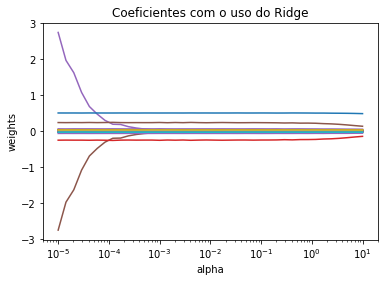

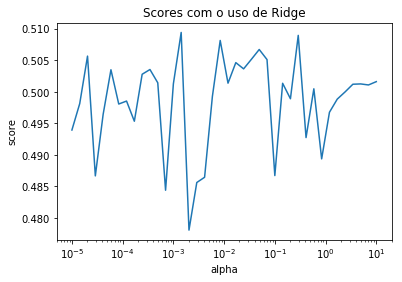

nº colunas:  1
[(0.48000990357611917, 'INSE_AB')]
melhor score:  0.5094264628947796


In [119]:
ridge_aplicada(esc_rmsp, alphas)

In [26]:
def lasso_aplicada(df, alphas):
    new_df = pd.merge(df, nota, on = 'CODMEC')
    if 'ANO' in new_df.columns:
        new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    else:
        new_df.drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
    data = new_df.drop('Classificacao', axis = 1)
    target = new_df.Classificacao
    coefs = []
    score = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    for val in alphas:
        lasso = Lasso(alpha = val, tol = 0.001)
        lasso.fit(data, target)
        coefs.append(lasso.coef_)
        score.append(lasso.score(data,target))
    
    features_values = list(zip(lasso.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do lasso')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de lasso')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.1]
    print('nº colunas: ', len(features_values))
    print(features_values)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


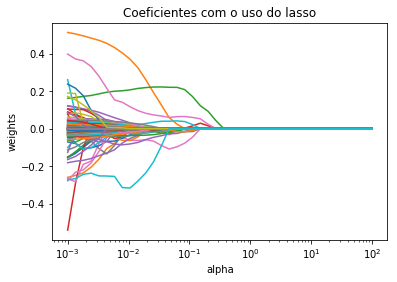

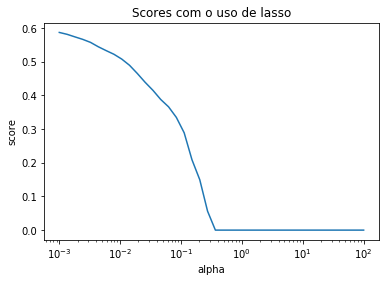

nº colunas:  0
[]


In [27]:
n_alphas = 40
alphas = np.logspace(-3, 2, n_alphas)
lasso_aplicada(dados_escolares, alphas)

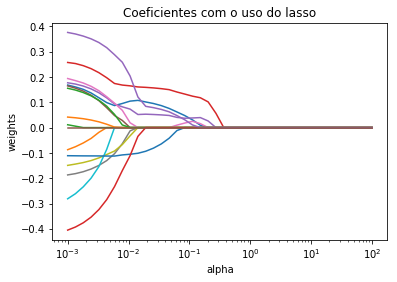

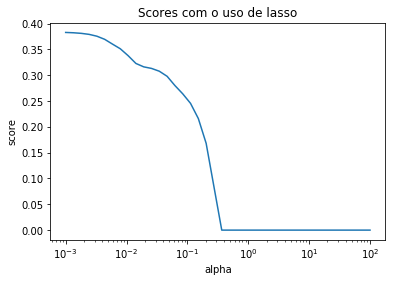

nº colunas:  0
[]


In [28]:
lasso_aplicada(rendimento, alphas)

C:\Users\giova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\giova\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


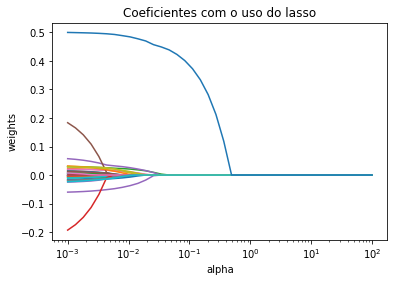

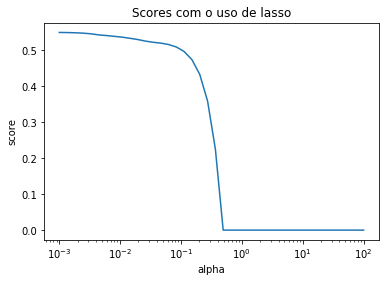

nº colunas:  0
[]


In [29]:
lasso_aplicada(esc_rmsp, alphas)